# Basic Technical Indicators

Explore and examine the mathematical concepts behind common technical indicators.

### Import libraries

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
from matplotlib import pyplot as plt
import mplfinance as mpf
from ta.trend import ADXIndicator 

### Download stock data for Nvidia
Data taken from last 4 years

In [4]:
nvidia_data = yf.download('AAPL',start= "2020-09-23", end="2024-09-23")
print(nvidia_data[['Open', 'High', 'Low', 'Adj Close', 'Volume']])

[*********************100%***********************]  1 of 1 completed

                  Open        High         Low   Adj Close     Volume
Date                                                                 
2020-09-23  111.620003  112.110001  106.769997  104.682472  150718700
2020-09-24  105.169998  110.250000  105.000000  105.757454  167743300
2020-09-25  108.430000  112.440002  107.669998  109.725044  149981400
2020-09-28  115.010002  115.320000  112.779999  112.344048  137672400
2020-09-29  114.550003  115.309998  113.570000  111.493858   99382200
...                ...         ...         ...         ...        ...
2024-09-16  216.539993  217.220001  213.919998  216.320007   59357400
2024-09-17  215.750000  216.899994  214.500000  216.789993   45519300
2024-09-18  217.550003  222.710007  217.539993  220.690002   59894900
2024-09-19  224.990005  229.820007  224.630005  228.869995   66781300
2024-09-20  229.970001  233.089996  227.619995  228.199997  318679900

[1005 rows x 5 columns]


### Plot the stock proce

Use mplfinance to plot the stock price, with a volume subplot

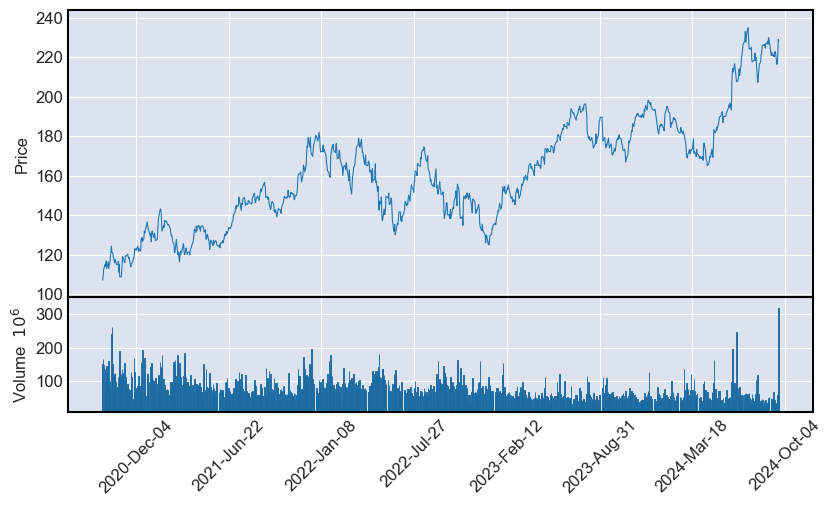

In [5]:
mpf.plot(nvidia_data, type = 'line', volume = True, figratio = (18,10), show_nontrading = True)

### Define a moving average function

Here we build a moving acerage function. We have to pad the beginning of the list with NaN values. 

In [6]:
def mov_avg(data, window):
    mavg = []
    for j in range(len(data)):            # Loop through the dataset
        if j < window:                    # Check that we are atleast the window into the dataset
            mavg.append(np.nan)           # If we are, add NaN value to the moving average dataset
        else:
            l = 0                         # Define a variable that will sum up the previous values in the dataset
            for i in range(window):       
                l += data[j-i]            # Loop through all the previous datappints in the window
            k = l/window                  # Take the average over the windown period
            mavg.append(k)                # Add this toothe moving average dataset
    return mavg


We plot the moving average for differnet window lengths. We see that the shorter the window length the more sensitive the line is to the sharp movements of the stock, and vice versa for longer windows which show the slower trends.

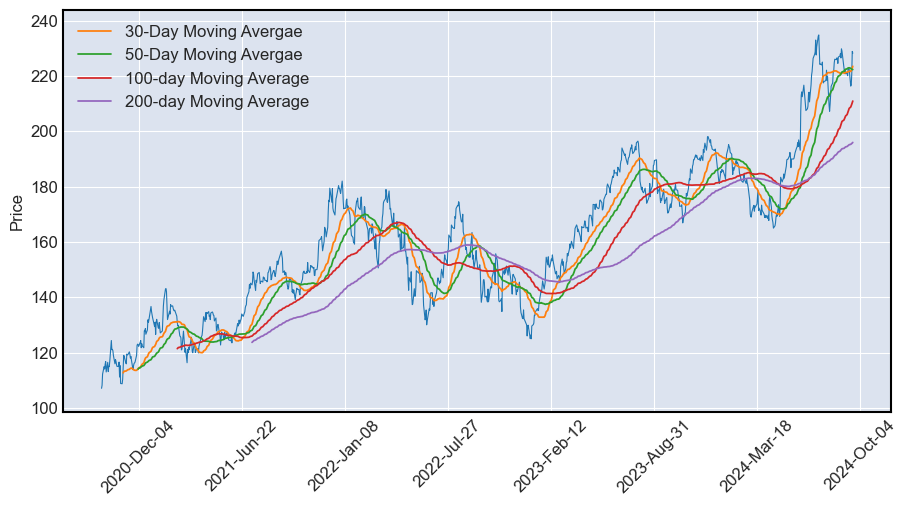

In [9]:
mavg_30 = mov_avg(nvidia_data['Adj Close'], 30)
mavg_50 = mov_avg(nvidia_data['Adj Close'], 50)
mavg_100 = mov_avg(nvidia_data['Adj Close'], 100)
mavg_200 = mov_avg(nvidia_data['Adj Close'], 200)

adp_100 = mpf.make_addplot(mavg_100, type = 'line', label = '100-day Moving Average')
adp_30 = mpf.make_addplot(mavg_30, type = 'line', label = '30-Day Moving Avergae')
adp_200 = mpf.make_addplot(mavg_200, type = 'line', label = '200-day Moving Average')
adp_50 = mpf.make_addplot(mavg_50, type = 'line', label = '50-Day Moving Avergae')

mpf.plot(nvidia_data, type = 'line', figratio = (20,10), show_nontrading = True, addplot = [adp_30, adp_50, adp_100, adp_200])

We can use this diffrence in sensitivity to identify momentum shifts in the price. When a shorter moving average crosses a longer moving average, this indicates a recent change in momentum; if it crosses from below to above, it suggests prices are rising, and above to below, prices are falling. We can use this to define entry and exit points.

Add the moving average data to the total dataset.

In [10]:
nvidia_data['SMA 30'] = mavg_30
nvidia_data['SMA 50'] = mavg_50
nvidia_data['SMA 100'] = mavg_100
nvidia_data['SMA 200'] = mavg_200

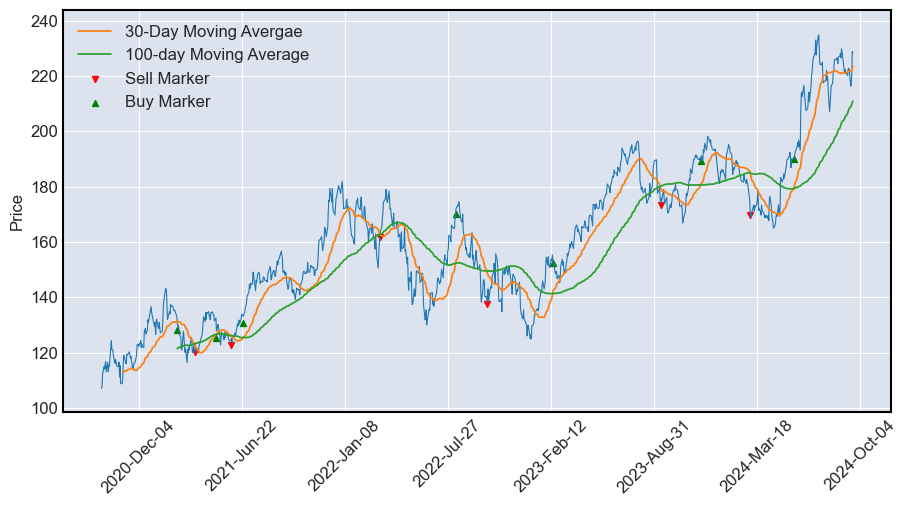

In [11]:
# Signal variable that is 1 where the 30 day MA is greater than the 100 day and 0 when below. 
nvidia_data['Signal'] = np.where(nvidia_data['SMA 30'] > nvidia_data['SMA 100'], 1, 0)

# However this will highlight all points and not just the crossing points. We now take the difference to find when we 
# change from above (1) to below(0)
nvidia_data['Position'] = nvidia_data['Signal'].diff()

# Buy signals when the difference is 1 (signal goes from 0 to 1). We use the Adj Close price inorder to plot on graph
nvidia_data['SMA Buy'] = np.where(nvidia_data['Position'] == 1, nvidia_data['Adj Close'], np.NAN)

# Sell sginalswhen the difference is -1 (signal from 1 to 0)
nvidia_data['SMA Sell'] = np.where(nvidia_data['Position'] == -1, nvidia_data['Adj Close'], np.NAN)

# Plot thses markers on a graph
adp_buy = mpf.make_addplot(nvidia_data['SMA Buy'], type = 'scatter', label = 'Buy Marker', marker='^', color='green')
adp_sell = mpf.make_addplot(nvidia_data['SMA Sell'], type = 'scatter', label = 'Sell Marker', marker='v', color='red')

mpf.plot(nvidia_data, type = 'line', figratio = (20,10), show_nontrading = True, addplot = [adp_30, adp_100, adp_sell, adp_buy])

We can see the buy and sell markers lining up with the crossover points. To profit from this we want a buy marker to be followed by a higher sell marker. We can see that it doesnt always happen, so its not a bullet proof indicator. 

Another indicator we can use relies on the tendency of price to revert back to its mean. We can looke at the standard deviation of the moving average, these are known as the Bollinger bands. We will use a 50day moving average and plot +/- 2 std dev.

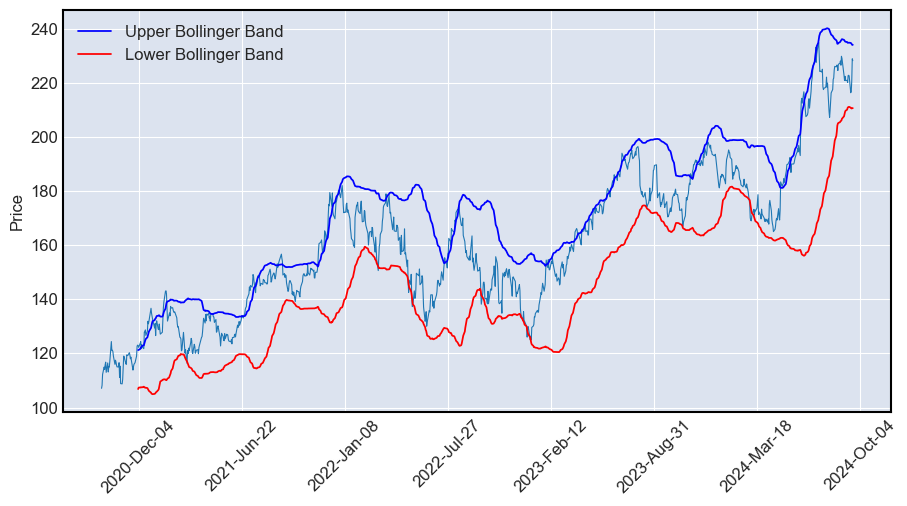

In [19]:
nvidia_data['Upper Bollinger Band'] = nvidia_data['SMA 50'] + 2*nvidia_data['Adj Close'].rolling(window=50).std()

nvidia_data['Lower Bollinger Band'] = nvidia_data['SMA 50'] - 2*nvidia_data['Adj Close'].rolling(window=50).std()

adp_ub = mpf.make_addplot(nvidia_data['Upper Bollinger Band'], type = 'line', label = 'Upper Bollinger Band', marker='--', color='blue')
adp_lb = mpf.make_addplot(nvidia_data['Lower Bollinger Band'], type = 'line', label = 'Lower Bollinger Band', marker='--', color='red')

mpf.plot(nvidia_data, type = 'line', figratio = (20,10), show_nontrading = True, addplot = [adp_ub, adp_lb])

From the graph we see the this +/-2 std dev band, constrains the price rather well. It bounces around, and you can see instances where it hits the bottom and bounces up to the middle or even further.

We can say that if the price drops to 2std dev below the moving average, we would expect it to return to the average or to 2std dev above. We can set our buy signal as when the price hits the lower bollinger band and a sell signal when it hits the top band.

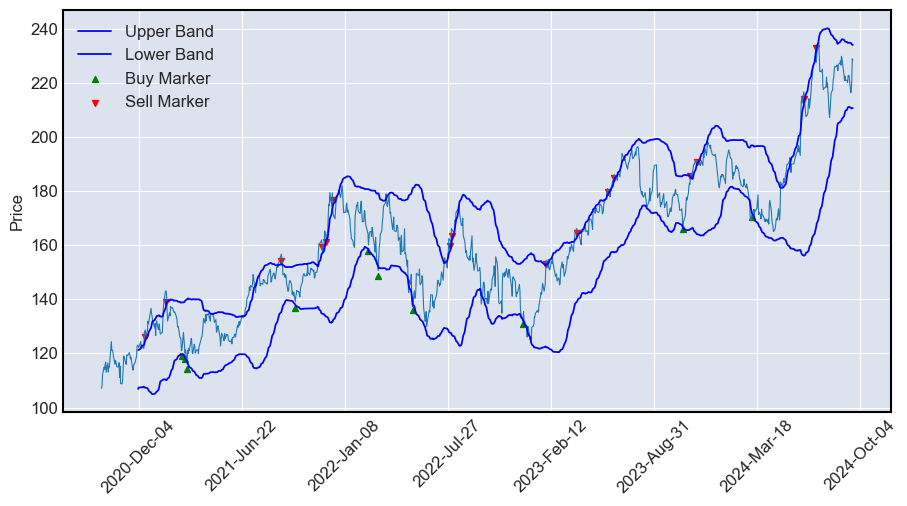

In [22]:
# We find the crossing points where the price is below the lower bollinger band AND the previous (shift(-1)) was 
# above or equal to the lower bollinger band
nvidia_data['Cross Above Lower'] = (nvidia_data['Adj Close'] < nvidia_data['Lower Bollinger Band']) & (nvidia_data['Adj Close'].shift(-1) >= nvidia_data['Lower Bollinger Band'])

# We find the crossing points where the price is above the upper bollinger band AND the previous (shift(-1)) was 
# below or equal to the upper bollinger band
nvidia_data['Cross Below Upper'] = (nvidia_data['Adj Close'] > nvidia_data['Upper Bollinger Band']) & (nvidia_data['Adj Close'].shift(-1) <= nvidia_data['Upper Bollinger Band'])

# Find where the crossing conditions are true
nvidia_data['Bollinger Buy'] = np.where(nvidia_data['Cross Above Lower'], nvidia_data['Adj Close'], np.NAN)
nvidia_data['Bollinger Sell'] = np.where(nvidia_data['Cross Below Upper'], nvidia_data['Adj Close'], np.NAN)

# Add plots for buy/sell markers
adp_buy_b = mpf.make_addplot(nvidia_data['Bollinger Buy'], type='scatter', label='Buy Marker', marker='^', color='green')
adp_sell_b = mpf.make_addplot(nvidia_data['Bollinger Sell'], type='scatter', label='Sell Marker', marker='v', color='red')

# Add plots for the Bollinger Bands
adp_upper_band = mpf.make_addplot(nvidia_data['Upper Bollinger Band'], type='line', color='blue', label='Upper Band')
adp_lower_band = mpf.make_addplot(nvidia_data['Lower Bollinger Band'], type='line', color='blue', label='Lower Band')


# Plotting the data with Bollinger Bands and buy/sell markers
mpf.plot(nvidia_data, type='line', figratio=(20, 10), show_nontrading=True,
         addplot=[adp_upper_band, adp_lower_band, adp_buy_b, adp_sell_b])

We can see that the buy markers appear when the price hits the lower band and the sell markers hit the top band. Whilst its not perfect as we have runs of sell markers as the price follows closely the upper band , we can see the idea behind this concept.


To improve this we can include a second pair of bands at a smaller standard deviation from the MA. This will produce a pair of 'Bollinger Lanes' that we can use to show strong upwards or downwards movements.

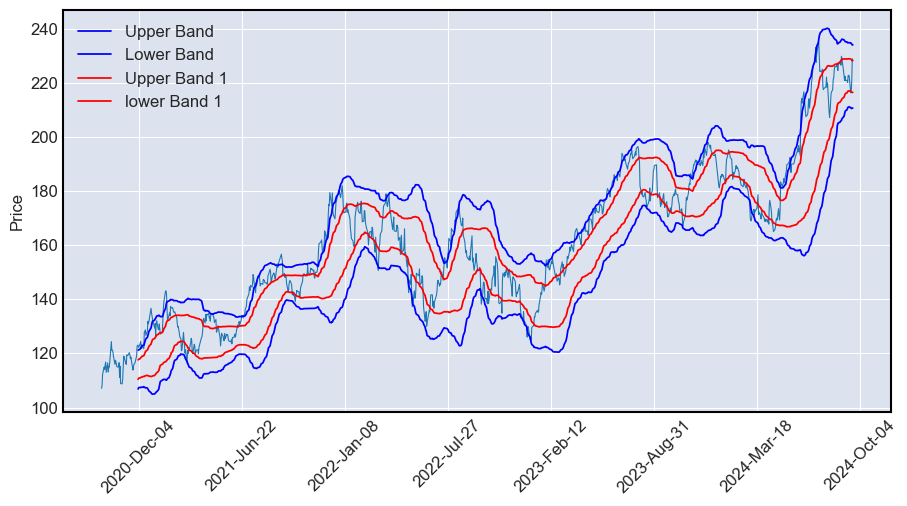

In [23]:
adp_upper_band_1 = mpf.make_addplot((nvidia_data['SMA 50'] + 1*nvidia_data['Adj Close'].rolling(window=50).std()), type='line', color='red', label='Upper Band 1')
adp_lower_band_1 = mpf.make_addplot((nvidia_data['SMA 50'] - 1*nvidia_data['Adj Close'].rolling(window=50).std()), type='line', color='red', label='lower Band 1')
adp_upper_band = mpf.make_addplot(nvidia_data['Upper Bollinger Band'], type='line', color='blue', label='Upper Band')
adp_lower_band = mpf.make_addplot(nvidia_data['Lower Bollinger Band'], type='line', color='blue', label='Lower Band')


# Plotting the data with Bollinger Bands and buy/sell markers
mpf.plot(nvidia_data, type='line', figratio=(20, 10), show_nontrading=True,
         addplot=[adp_upper_band, adp_lower_band,adp_upper_band_1,adp_lower_band_1])

We can see how the second set of bands contains the strong runs in upwards or downwards movements. This can be used to hold positions once a long or shart has been entered, even if the price moves out of these postion conditions. FOr example, if we say buy when price drops below the lower 2sd bollinger band but hold even if it rises back above but doesnt cross above the 1sd band, we can hold this postiion for longer.


We can also use momentum strength indicators to reinforce other indicators. For example the RSI measures a stocks strengtha nd speed of recent price movements. It allows us to see how overbought (RSI > 70) or oversold (RSI < 30) and we can use this to reinforce buy and sell indicators. We might buy when its oversold, and sell when overbought.

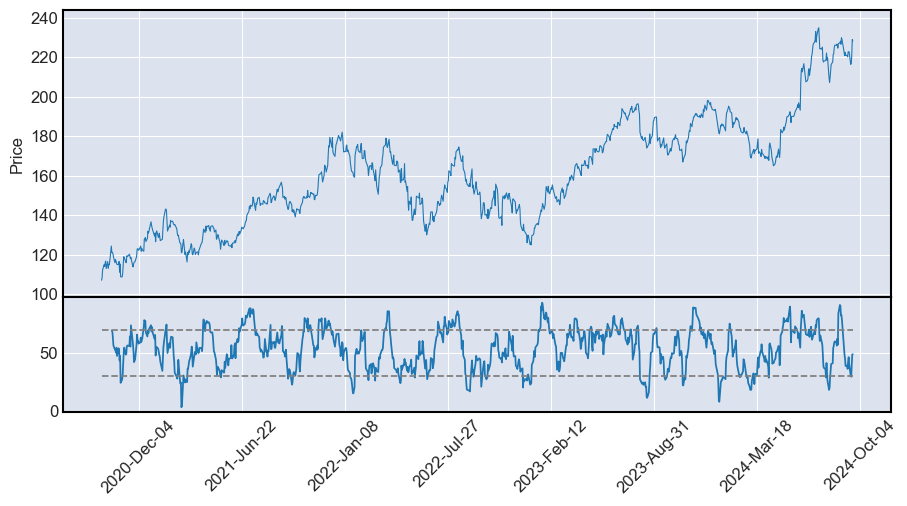

In [10]:
# To calculate the RSI we need t calculate the difference in prices between successive intervals
change = nvidia_data["Adj Close"].diff()
change.dropna(inplace=True)
change_up = change.copy()
change_down = change.copy()

# Keep only the positive differences in the change up list
change_up[change_up<0] = 0

# Keep only the negative difference in the change down list
change_down[change_down>0] = 0

# Take the average upwawrds movement and average downwards movement over a a 14 day window
avg_up = change_up.rolling(14).mean()
avg_down = change_down.rolling(14).mean().abs()

# RSI is calculated by the propertion of upards movements from total movement(up + down). We take as value between 0 and 100
nvidia_data['RSI'] = 100 * avg_up / (avg_up + avg_down)

# Plot on a subplot, with overbought and oversold lines
adp_rsi = [mpf.make_addplot(nvidia_data['RSI'], type = 'line', panel=1),
           mpf.make_addplot(np.full(len(nvidia_data['RSI']), 70), type = 'line', linestyle = '--', color = 'grey', panel=1),
           mpf.make_addplot(np.full(len(nvidia_data['RSI']), 30), type = 'line', linestyle = '--', color = 'grey', panel=1)]

mpf.plot(nvidia_data, type = 'line', figratio = (20,10), show_nontrading = True, addplot = adp_rsi)

We can see that the RSI occasionally to line up well with the price movements. For example at the start of 2023 we see the RSI fall below the oversold level, this is then followed by an increase in price till its over bought. Its not perfect and should be used to confrim other indicators.


Another movement indicator is the average directional index (ADX). It measures the strength of the trend in price movement. It doesnt itself measure the directin, only the magnitude. If we see an upwards trend in price accompanied by a high ADX it implies its a strong moevements, similarly a high ADX but a downwads trend indicates a strong movement. We use a built in function to calculate ADX. An ADX of below 25 is a weak trend and then above is a stronger, and increasing strength.

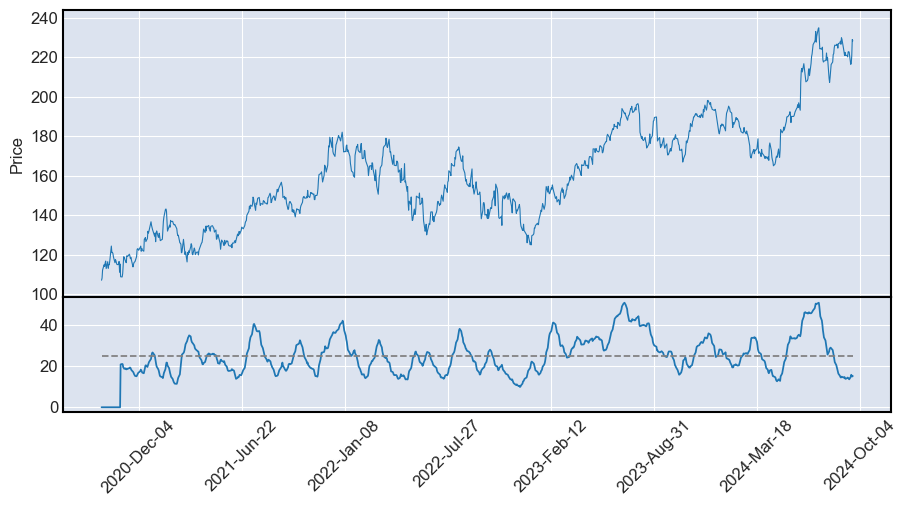

In [11]:
# Calculate ADX
adx_ind = ADXIndicator(high=nvidia_data["High"], low=nvidia_data["Low"], close=nvidia_data["Adj Close"], window= 14, fillna= False)
nvidia_data['ADX'] = adx_ind.adx()

# Plot ADX
adp_adx = [mpf.make_addplot(nvidia_data['ADX'], type = 'line', panel=1),
           mpf.make_addplot(np.full(len(nvidia_data['ADX']), 25), type = 'line', linestyle = '--', color = 'grey', panel=1)
          ]

mpf.plot(nvidia_data, type = 'line', figratio = (20,10), show_nontrading = True, addplot = adp_adx)

Again we see that the ADX above the 25 line occasionaly corresonds to strong upwards or downawards trends, but it isnt perfect. It also isnt instant, and often, once the ADX responds and moves to a strong level, the price moevemnt has stopped.


Another indicator we can use is a Moving Average Convergence/Divergence (MACD). This  indicator uses 2 Exponential moving averages, a 12 day and 26 day. We subtract the 26 day from the 12 day for the MACD line. We then use a 9 day EMA of the MACD line  as a signal line. We are interested in when the 9 day and MACD line cross. This can, similar to the simple MA crossover, show recent price movement momentum changes. If the smaller window signal line crosses above the MACD then it indicatees a buy signal and viceversa.

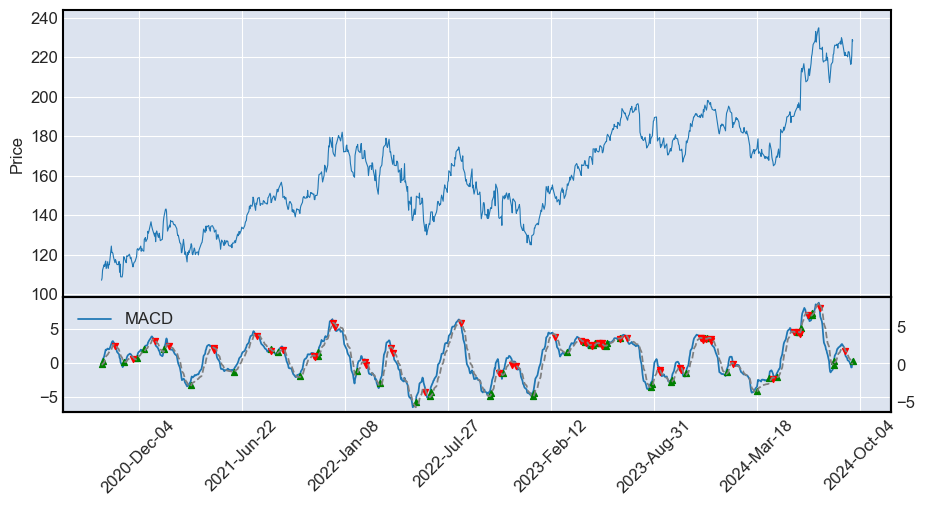

In [30]:
# Calculate the 12 day EMA
nvidia_data['EMA12'] = nvidia_data['Adj Close'].ewm(span=12, adjust=False).mean()

# Calculate the 26 day EMA
nvidia_data['EMA26'] = nvidia_data['Adj Close'].ewm(span=26, adjust=False).mean()

# Calculate MACD (EMA 12 - EMA 26)
nvidia_data['MACD'] = nvidia_data['EMA12'] - nvidia_data['EMA26']

# Calculate the 9 day EMA of MACD (Signal Line)
nvidia_data['Signal Line'] = nvidia_data['MACD'].ewm(span=9, adjust=False).mean()

# Generate buy/sell signals based on crossing MACD and Signal Line
nvidia_data['MACD Cross Above'] = (nvidia_data['MACD'] > nvidia_data['Signal Line']) & (nvidia_data['MACD'].shift(1) <= nvidia_data['Signal Line'])
nvidia_data['MACD Cross Below'] = (nvidia_data['MACD'] < nvidia_data['Signal Line']) & (nvidia_data['MACD'].shift(1) >= nvidia_data['Signal Line'])

# Select where the buy/sell conditions are met
nvidia_data['MACD Buy'] = np.where(nvidia_data['MACD Cross Above'], nvidia_data['MACD'], np.NAN)
nvidia_data['MACD Sell'] = np.where(nvidia_data['MACD Cross Below'], nvidia_data['MACD'], np.NAN)

# Add plots for buy/sell markers in MACD
adp_macd = [
    mpf.make_addplot(nvidia_data['MACD'], type='line', panel=1, label='MACD'),
    mpf.make_addplot(nvidia_data['Signal Line'], type='line', linestyle='--', color='grey', panel=1),
    mpf.make_addplot(nvidia_data['MACD Buy'], type='scatter', marker='^', color='green', panel=1),
    mpf.make_addplot(nvidia_data['MACD Sell'], type='scatter', marker='v', color='red', panel=1)
]

# Plotting the MACD data
mpf.plot(nvidia_data, type='line', figratio=(20, 10), show_nontrading=True, addplot=adp_macd)


We can see the buy and sell signals. They nicely correspond to good entry and exit points. 